# Applied Deep Learning: Project Codes - Training Part

In [46]:
import tensorflow as tf
from tensorflow.keras import backend
import tensorflow.keras.utils
import tensorflow.keras.layers as layers

In [47]:
import os
import math
import dlib
from imutils.face_utils import FaceAligner, rect_to_bb
import cv2
import imutils
import shutil
import matplotlib.pyplot as plt

import random
import numpy as np
from tensorflow.python.keras.utils.data_utils import Sequence

In [ ]:
!ls ./data/tra

## Part 0: Explore the dataset

For this project we use CASIA_WebFaces, avaible at https://github.com/happynear/AMSoftmax/issues/18

In [55]:
datapath = './data/CASIA-WebFace/'
outdatapath = './data/training/'

stats = []
for people_folder in os.listdir(datapath):
    stats.append(len(os.listdir(os.path.join(datapath, people_folder))))

In [64]:
print('Avg number of {} photo per person, min: {}, max: {}'.format(sum(stats)/len(stats), min(stats), max(stats)))
print("Total number of person: {}".format(len(os.listdir(datapath))))

Avg number of 46.75309692671395 photo per person, min: 2, max: 804
Total number of person: 10575


## Part 1: Data Preprocessing

Before we start the training, we need to preprocess the dataset to get a better result

### Face detection and Affine Transformation

In [8]:
# use dlib as face detection algorithm
sp_path = 'shape_predictor_68_face_landmarks.dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(sp_path)
fa = FaceAligner(predictor, desiredFaceWidth=128)

**Let's see a test image**

In [57]:
test_img = cv2.imread(os.path.join(datapath, '0000045', '001.jpg'))

In [58]:
test_img.shape

(250, 250, 3)

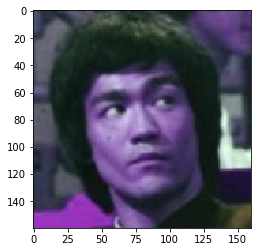

In [59]:
test_img = imutils.resize(test_img, width=160)

plt.imshow(test_img)
plt.show()

**Transorfomation Overview**

First, detect face in the photo and crop the face so that all photos in our dataset has same size photo.

Second, we going to use face landmarks produced by dlib to do transformation: make the eyes on the same line

In [60]:
gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)

x, y, w, h = rect_to_bb(rects[0])
faceOrig = imutils.resize(test_img[y:y+h, x:x+w], width=160)
faceAlign = fa.align(test_img, gray, rects[0])

Cropped Face

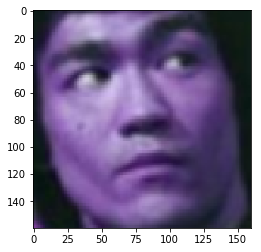

In [61]:
plt.imshow(faceOrig)
plt.show()

Transformed(Aligned) Face

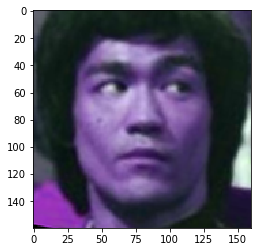

In [62]:
plt.imshow(faceAlign)
plt.show()

In [65]:
# Transform the whole training dataset using the method described above

def preprocessing(datapath, outdatapath, num_photo_per_person=16, num_person=1000):
    count = 0
    for people_folder in os.listdir(datapath):
        if len(os.listdir(os.path.join(datapath, people_folder))) < num_photo_per_person:
            continue # ignore the people has less than 16 photos

        res = transform_photo_in_dir(datapath, people_folder, outdatapath, num_photo_per_person)

        if res:
            count += 1
        if count % 100 == 0:
            print("processing No.{}".format(count))
            
        if count >= num_person:
            break 
    print("Finish")
        

In [66]:
# helper function for the function above

def transform_photo_in_dir(datapath, people_folder, outdatapath, num_photo_per_person=16):
    path = os.path.join(datapath, people_folder)
    count = 0
    os.mkdir(os.path.join(outdatapath, people_folder))
    for photo_path in os.listdir(path):
        img = cv2.imread(os.path.join(path, photo_path))
        img = imutils.resize(img, width=160)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        rects = detector(gray, 1)
        
        if len(rects) == 0:
            # no face detected
            continue
        
        faceAligned = fa.align(img, gray, rects[0])
        
        cv2.imwrite(os.path.join(outdatapath, people_folder, photo_path), faceAligned)
        count += 1
        if count == num_photo_per_person:
            break 
    
    if count < num_photo_per_person:
        #not enough photo, we don't use this person's photo
        deletepath = os.path.join(outdatapath, people_folder)
        if os.path.isdir(deletepath):
            shutil.rmtree(deletepath)
        return False
    
    return True


In [ ]:
# Do the propocessing on CASIA_WebFace Dataset

preprocessing(datapath, outdatapath)

## Part 2 Model Declaration

In [67]:
# below are building blocks for mobilenet. Most of the code is copies from Keras.application.mobilenet
# with a slightly modifcation to produce the 128d vector in the end

def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    channel_axis = 1 if backend.image_data_format() == 'channel_first' else -1
    filters = int(filters*alpha)
    
    x = layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv1_pad')(inputs)
    x = layers.Conv2D(filters, kernel,
                      padding='valid', 
                      use_bias=False, 
                      strides=strides,
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return layers.ReLU(6., name='conv1_relu')(x)

def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1):
  
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    if strides == (1, 1):
        x = inputs
    else:
        x = layers.ZeroPadding2D(((0, 1), (0, 1)), name='conv_pad_%d' % block_id)(inputs)
     
    x = layers.DepthwiseConv2D((3, 3), 
                               padding='same' if strides == (1, 1) else 'valid', 
                               depth_multiplier=depth_multiplier,
                               strides=strides,
                               use_bias=False,
                               name='conv_dw_%d' % block_id)(x)
    x = layers.BatchNormalization(
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = layers.ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

    x = layers.Conv2D(pointwise_conv_filters, (1, 1),
                      padding='same',
                      use_bias=False,
                      strides=(1, 1),
                      name='conv_pw_%d' % block_id)(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  name='conv_pw_%d_bn' % block_id)(x)
    return layers.ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

In [112]:
# main function for defining mobilenet

def MobileNet(input_shape=None,
              alpha=1.0,
              depth_multiplier=1,
              dropout=1e-3,
              include_top=True,
              weights='imagenet',
              input_tensor=None,
              pooling=None,
              classes=1000,
              **kwargs):


    # Determine proper input shape and default size.
    if input_shape is None:
        default_size = 224
    else:
        if backend.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    if backend.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
        
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    
    img_input = layers.Input(shape=input_shape)

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)
    
    # HERE IS THE DIFFERENT between original mobilenet and our mobilenet
    x = layers.GlobalAveragePooling2D(name='AvgPool')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, use_bias=False, name='final_dense')(x)
    
    # output is a 128d vector
    x = layers.Lambda(lambda x : backend.l2_normalize(x, axis=-1))(x)
    

    inputs = img_input

    # Create model.
    model = tf.keras.Model(inputs, x, name='mobilenet_%0.2f_%s' % (alpha, rows))


    return model


## Part 3: Training

First, since we need to ensure we can have lots of triplet in each batch, we need to write a custom data generator. The generator will ensure we can find many valid triplet in a single batch

In [5]:


class DataGenerator(Sequence):
    def __init__(self, datapath, num_photo_per_person=16, batch_size=64, num_photo_per_batch_person=4, img_size=(160, 160), shuffle=True):
        self.datapath = datapath
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.nppp = num_photo_per_person
        self.nppbp = num_photo_per_batch_person
        self.__get_list_ids()
        self.__build_labels()
        self.on_epoch_end()

    def __get_list_ids(self):
        self.ids = os.listdir(self.datapath)
        return self.ids
    
    def __build_labels(self):
        self.id_to_labels = {}
        for i, id in enumerate(self.ids):
            self.id_to_labels[id] = i
        return self.id_to_labels

    def __get_indexes(self):
        if self.shuffle:
            random.shuffle(self.ids)

        self.indexes = []
        self.y = []
        # since every id contain exactly 16 photos, on each batch, we want 4 photos from each id:
        for i, id in enumerate(self.ids*(self.nppp//self.nppbp)):
            photos = sorted(os.listdir(os.path.join(self.datapath, id)))
            tmp = photos[(i//len(self.ids))*self.nppbp : (i//len(self.ids))*self.nppbp+ self.nppbp]
            for photo in tmp:
                photo_path = os.path.join(self.datapath, id, photo)
                self.indexes.append(photo_path)
                self.y.append(self.id_to_labels[id])


    def on_epoch_end(self):
        self.__get_indexes()
        if self.shuffle:
            self.__get_indexes()


    def __len__(self):
        return int(np.floor(len(self.indexes) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]

        return np.array([
            np.around(cv2.resize(cv2.imread(file_name), self.img_size)/255.0, decimals=12)
                for file_name in batch_x]), np.array(batch_y, dtype=np.int32)

In [6]:
# define functions to find anchor positive negative triplets
# REF: https://github.com/omoindrot/tensorflow-triplet-loss/blob/master/model/triplet_loss.py


def _get_anchor_positive_triplet_mask(labels):
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask

def _get_anchor_negative_triplet_mask(labels):
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

In [70]:
# Here we define the triplet loss function
# REF: https://github.com/omoindrot/tensorflow-triplet-loss/blob/master/model/triplet_loss.py


def _pairwise_distances(embeddings, squared=False):
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


# Batch Hard triplet loss: find the distance between the hardest positive and the hardest negative as the loss
def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

# Batch All triplet loss: find all valid triplet loss and then avg the loss
def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


In [32]:
# loss function wrapper

def triplet_loss(y_true, y_pred):
    margin = 0.5
    return batch_hard_triplet_loss(y_true, y_pred, margin)

**Start with training with less data**

In [71]:
datagen = DataGenerator('./data/training') # number of person: 1000, photo per person: 16, total: 16000 photos
model = MobileNet((160, 160, 3))
model.compile(loss=triplet_loss, optimizer='sgd')

In [72]:
model.fit_generator(generator=datagen, epochs=5)

Epoch 1/5
250/250 [==============================] - 63s 251ms/step - loss: 0.7218
Epoch 2/5
250/250 [==============================] - 44s 177ms/step - loss: 0.6217
Epoch 3/5
250/250 [==============================] - 44s 177ms/step - loss: 0.5982
Epoch 4/5
250/250 [==============================] - 44s 176ms/step - loss: 0.5862
Epoch 5/5
250/250 [==============================] - 44s 177ms/step - loss: 0.5782


In [73]:
model.save_weights('initial_model.h5')

Let find three images to see their distance among each other

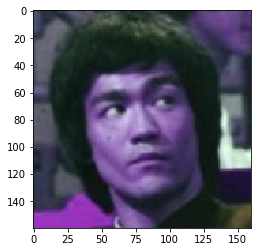

In [74]:
plt.imshow(test_img)
plt.show()

In [75]:
src = model.predict(tf.expand_dims(test_img, 0), steps=1)

In [105]:
# this function can help us find the distance between the face in two photos, if dist are less than a certain amount
# then we see these two photo as same person

def get_euclideandistance(src, tar):
    ed = src - tar
    ed = np.sum(np.multiply(ed, ed), 1)
    return np.sqrt(ed)

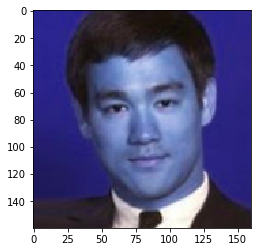

In [79]:
test_img_2 = cv2.resize(cv2.imread(os.path.join(datapath, '0000045', '009.jpg')), (160, 160))
plt.imshow(test_img_2)
plt.show()

In [80]:
tar_pos = model.predict(tf.expand_dims(test_img_2, 0), steps=1)

In [84]:
dist = get_euclideandistance(src[0], tar_pos[0])
print("Distance between Anchor and Positive:")
print(dist)

Distance between Anchor and Positive:
1.4100027


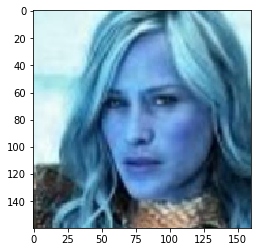

In [85]:
test_img_3 = cv2.resize(cv2.imread(os.path.join(datapath, '0000099', '001.jpg')), (160, 160))
plt.imshow(test_img_3)
plt.show()

In [86]:
tar_neg = model.predict(tf.expand_dims(test_img_3, 0), steps=1)

In [87]:
dist = get_euclideandistance(src[0], tar_neg[0])
print("Distance between Anchor and Positive:")
print(dist)

Distance between Anchor and Positive:
1.4100034


...Not so good, although the distance between positive and anchor is smaller than negative and anchor, the distance is too small.

Let trained with more data

In [ ]:
# First let's process a larger training set
# this time: we aim to find 8000 person with 30 photo each person

inputdata = './data/CASIA-WebFace/'
outputdata_large = './data/training_large/'

preprocessing(inputdata, outputdata_large, 30, 8000)

In [89]:
outputdata_large = './data/training_large/'
stats = []
for people_folder in os.listdir(outputdata_large):
    stats.append(len(os.listdir(os.path.join(outputdata_large, people_folder))))

In [90]:
print("Number of People: {}, min: {}, max: {}".format(len(stats), min(stats), max(stats)))

Number of People: 4115, min: 30, max: 30


Unfortunatly, we cannot find 8000 people with at least 30 image, we will use 4115 people with 30 image for each person

In [11]:
# define a new model

model_large = MobileNet((160, 160, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model_large.compile(loss=triplet_loss, optimizer='adam')

Instructions for updating:
Use tf.cast instead.


In [9]:
# this time we going to training on much larget data

datagen_large = DataGenerator('./data/training_large/', num_photo_per_person=30, batch_size=40, num_photo_per_batch_person=5)

In [14]:
model_large.fit_generator(generator=datagen_large, epochs=5)
model_large.save_weights("model_large_adam.h5")
model_large.save("model_large_adam_model.h5")

Epoch 1/5
3086/3086 [==============================] - 366s 119ms/step - loss: 0.5004
Epoch 2/5
3086/3086 [==============================] - 369s 119ms/step - loss: 0.5003
Epoch 3/5
3086/3086 [==============================] - 368s 119ms/step - loss: 0.5003
Epoch 4/5
3086/3086 [==============================] - 368s 119ms/step - loss: 0.5003
Epoch 5/5
3086/3086 [==============================] - 368s 119ms/step - loss: 0.5003


## Part 4: Evalutaion on LFW dataset

In [76]:
# load the model

model = MobileNet((160, 160, 3))
model.load_weights('./model_large_adam.h5')

In [113]:
# some helper function for us to evaluate on LFW dataset


# Apply the same transformation as we did to the training data to the testing data
def align_lfw(lfw_dir, output_dir, faceAligner, detector):
    for people_folder in os.listdir(lfw_dir):
        align_one_person(lfw_dir, people_folder, output_dir, faceAligner, detector)

def align_one_person(lfw_dir, people_folder, output_dir, faceAligner, detector):
    tmppath = os.path.join(lfw_dir, people_folder)
    if not os.path.exists(os.path.join(output_dir, people_folder)):
        os.mkdir(os.path.join(output_dir, people_folder))
    for photo_path in os.listdir(tmppath):
        img = cv2.imread(os.path.join(tmppath, photo_path))
        img = imutils.resize(img, width=160)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        rects = detector(gray, 1)
        if len(rects) == 0:
            continue
        faceAligned = faceAligner.align(img, gray, rects[0])
        cv2.imwrite(os.path.join(output_dir, people_folder, photo_path), faceAligned)

        
# LFW provide pairs for testing 
# It has the following format:
# A 1 2 
# A 1 B 2
# A, B are person's name
# 1, 2 are photo's filename
# If there are two person name in one line, mean the photos are different person
# Otherwise, the two photo are from the same person
# To view pairs: http://vis-www.cs.umass.edu/lfw/pairs.txt

# processing LFW Pairs: generate testing data and labels
def processing_pairs(lfw_dir, pairs_filepath):
    pair_paths, labels = [], []

    with open(pairs_filepath, 'r') as f:
        lines = f.readlines()
        for line in lines[1:]:
            parts = line.strip().split()
            if len(parts) == 3:
                photo1_path = os.path.join(lfw_dir, parts[0], parts[0] + '_' + '%04d' % int(parts[1]) + '.'+ 'jpg')
                photo2_path = os.path.join(lfw_dir, parts[0], parts[0] + '_' + '%04d' % int(parts[2]) + '.'+ 'jpg')
                label = True
            elif len(parts) == 4:
                photo1_path = os.path.join(lfw_dir, parts[0], parts[0] + '_' + '%04d' % int(parts[1]) + '.'+ 'jpg')
                photo2_path = os.path.join(lfw_dir, parts[2], parts[2] + '_' + '%04d' % int(parts[3]) + '.'+ 'jpg')
                label = False
            if os.path.exists(photo1_path) and os.path.exists(photo2_path):
                pair_paths.append((photo1_path, photo2_path))
                labels.append(label)
    return pair_paths, labels

# helper function for loadding image into batch
def load_image(lfw_dir, image_filebatch):
    n_img = len(image_filebatch)
    res1 = np.zeros((n_img, 160, 160, 3))
    res2 = np.zeros((n_img, 160, 160, 3))

    for i in range(n_img):
        file1, file2 = image_filebatch[i]
        img1 = cv2.imread(file1)
        img2 = cv2.imread(file2)
        img1 = np.around(img1/255.0, decimals=12)
        img2 = np.around(img2/255.0, decimals=12)

        res1[i, :, :, :] = img1
        res2[i, :, :, :] = img2
    return res1, res2

# Given a threshold, evaluate the accuracy under this threshold
def calculate_acc(threshold, dist, labels):
    pred = np.less(dist, threshold) # find the prediction under current threshold
    tp = np.sum(np.logical_and(pred, labels))
    tn = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(labels)))
    # print(tp, tn, dist.size)
    return float(tp+tn)/dist.size

# Given two groups of embeddings, each index i in two groups are pairs
# Evaluate the accuracy best finding the best threshold to achieve the maximum accuracy
# Return the maximum accuracy
def evaluate_embeddings(embeddings1, embeddings2, labels):
    thresholds = np.arange(0, 3, 0.0001) # list of threshold

    max_accuracy = 0
    max_threshold = 0
    dist = get_euclideandistance(embeddings1, embeddings2) # find the dist
    for threshold in thresholds:
        acc = calculate_acc(threshold, dist, labels)
        if acc > max_accuracy:
            max_accuracy = acc
            max_threshold = threshold
    return max_accuracy, max_threshold

# Wrapper function for evaluting on LFW
def evaluate_on_lfw(lfw_dir, pairs_filepath, model, batch_size=64):
    # Get all pair information
    pairs_paths, labels = processing_pairs(lfw_dir, pairs_filepath)
    
    n_img = len(pairs_paths)
    embeddings1 = np.zeros((n_img, 128))
    embeddings2 = np.zeros((n_img, 128))
    n_batch = int(math.ceil(1.0*n_img / batch_size))
    
    print("Running forward")
    for i in range(n_batch):
        start_idx, end_idx = i*batch_size, min((i+1)*batch_size, n_img)
        image_filebatch = pairs_paths[start_idx:end_idx]
        image_batch1, image_batch2 = load_image(lfw_dir, image_filebatch)

        y1 = model.predict_on_batch(image_batch1)
        y2 = model.predict_on_batch(image_batch2)
        embeddings1[start_idx:end_idx, :] = y1
        embeddings2[start_idx:end_idx, :] = y2

    # save temp result
    np.savetxt('embeddings1.csv', embeddings1, delimiter=',')
    np.savetxt('embeddings2.csv', embeddings2, delimiter=',')

    print("Finish Generating Embeddings")

    acc = evaluate_embeddings(embeddings1, embeddings2, labels)
    print("Accuracy: {}".format(acc))

# used for running evaluation on saved embeddings
def load_embedding_from_file(file1, file2, lfw_dir, pairs_filepath):
    _, labels = processing_pairs(lfw_dir, pairs_filepath)
    embeddings1 = np.genfromtxt(file1, delimiter=',')
    embeddings2 = np.genfromtxt(file2, delimiter=',')
    
    acc = evaluate_embeddings(embeddings1, embeddings2, labels)
    
    print("Accuracy: {}".format(acc))
    

In [19]:
sp_path = 'shape_predictor_68_face_landmarks.dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(sp_path)
fa = FaceAligner(predictor, desiredFaceWidth=160)

In [62]:
align_lfw('./lfw', './lfw_aligned', fa, detector)

In [ ]:
evaluate_on_lfw('./lfw_aligned', './pairs.txt', model)

In [108]:
load_embedding_from_file('./embeddings1.csv', './embeddings2.csv', './lfw_aligned', './pairs.txt')

Accuracy: (0.5009348971613122, 0.0)


### Let try with a different triplet strategy

In [110]:
def triplet_loss_batch_all(y_true, y_pred):
    margin = 1
    return batch_all_triplet_loss(y_true, y_pred, margin)[0]

In [42]:
model_batch_all = MobileNet((160, 160, 3))
model_batch_all.compile(loss=triplet_loss_batch_all, optimizer='adam')
datagen = DataGenerator('./data/training_large/', num_photo_per_person=30, batch_size=40, num_photo_per_batch_person=5)

model_batch_all.fit_generator(generator=datagen, epochs=2)
model_batch_all.save_weights("model_large_adam_batchall.h5")
model_batch_all.save("model_large_adam_batchall_model.h5")

Epoch 1/2
3086/3086 [==============================] - 382s 124ms/step - loss: 1.0000
Epoch 2/2
3086/3086 [==============================] - 374s 121ms/step - loss: 1.0000


In [43]:
evaluate_on_lfw('./lfw_aligned', './pairs.txt', model_batch_all)

Running forward
Finish Generating Embeddings
Accuracy: (0.5009348971613122, 0.0)


### Let try with a larger learning rate

In [51]:
from tensorflow.keras.optimizers import Adam

model_large_lr = MobileNet((160, 160, 3))
optimizer = Adam(lr=1)
model_large_lr.compile(loss=triplet_loss, optimizer=optimizer)
datagen = DataGenerator('./data/training_large/', num_photo_per_person=30, batch_size=40, num_photo_per_batch_person=5)

history = model_large_lr.fit_generator(generator=datagen, epochs=2)
model_large_lr.save_weights("model_large_adam_large_lr.h5")
model_large_lr.save("model_large_adam_large_lr_model.h5")

Epoch 1/2
3086/3086 [==============================] - 395s 128ms/step - loss: 0.5005
Epoch 2/2
3086/3086 [==============================] - 379s 123ms/step - loss: 0.5003


In [54]:
evaluate_on_lfw('./lfw_aligned', './pairs.txt', model_large_lr) 

Running forward
Finish Generating Embeddings
Accuracy: (0.5009348971613122, 0.0)


In [115]:
!du -sh model_large_adam_large_lr_model.h5

39M	model_large_adam_large_lr_model.h5


## Part 5: Discussion

If we look closer into the loss value, basically the neural network is trapped in a local minima. The model is foces to produce the same embedding for most positive and negative photos. Since the loss == margin at the end. 

Possible Reasons & Solutions:

1. Increase the training size, in original Facenet paper, they use about 3 million images to achieve 70% accuracy. However, we cannot have that dataset

2. In origin paper, people use Inception Net as the primary CNN, here since we want to reduce the size, we used MobileNet. However, the result shows that maybe MobileNet are not suitable for this task. As far as I read the literature, no other research use MoblieNet to train facenet before

3. Improve triplet selection strategy. Our data generator can only ensure that we can produce as many triplet as possible. However, we cannot garentee that we can have the desired triplet. 
